In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import (
    train_test_split,
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import (
    GradientBoostingClassifier,
    AdaBoostClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier

### Load the data

In [2]:
data = pd.read_csv("..\\Data\\BP_features.csv")
labels = pd.read_csv("..\\Data\\BP_labels.csv")

In [3]:
labels["0"]

0      120
1      140
2      150
3      130
4      110
      ... 
547    140
548    116
549    140
550    114
551    127
Name: 0, Length: 552, dtype: int64

In [4]:
def get_binary_class(value):
    # Normal Class for Max_BP (90-140)
    if value >= 90 and value <= 140:
        return 0
    # Abnormal Class for Max_BP (<90) or (>140)
    return 1

labels = labels["0"].apply(lambda x: get_binary_class(x))

In [5]:
labels.value_counts()

0
0    424
1    128
Name: count, dtype: int64

In [6]:
labels = np.ravel(labels)

### Splitting the Dataset

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42, shuffle=True
)

In [8]:
y_train.shape

(441,)

### Normalization

In [9]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Train and evaluate model

In [10]:
def train_evaluate_model(X_train, X_test, y_train, y_test, model, param_grid):

    bayes_search = BayesSearchCV(
        model,
        param_grid,
        cv=5,
        scoring="f1_macro",
        n_jobs=-1,
        random_state=42,
        n_iter=20,
    )
    bayes_search.fit(X_train, y_train)

    best_model = bayes_search.best_estimator_
    best_params = bayes_search.best_params_

    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Evaluation Metrics!
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    try:
        train_roc = roc_auc_score(y_train, bayes_search.predict_proba(X_train)[:, 1])
        test_roc = roc_auc_score(y_test, bayes_search.predict_proba(X_test)[:, 1])
        train_roc = np.round(train_roc * 100, 2)
        test_roc = np.round(test_roc * 100, 2)

    except:
        train_roc = "Not found"
        test_roc = "Not found"

    return (
        best_model,
        best_params,
        train_accuracy,
        test_accuracy,
        train_f1,
        test_f1,
        train_roc,
        test_roc,
    )

Parameter Grid for different models

In [11]:
models = {
    "Logistic Regression": [
        LogisticRegression(
            max_iter=2000, n_jobs=-1, random_state=42, class_weight={0: 1, 1: 3}
        ),
        {
            "C": Real(0.01, 10, prior="log-uniform"),
            "fit_intercept": [True, False],
            "penalty": ["l2", None],
            "solver": ["lbfgs", "newton-cg", "newton-cholesky", "sag"],
            "tol": Real(1e-5, 1e-3, prior="log-uniform"),
        },
    ],
    "Ridge Regression": [
        RidgeClassifier(random_state=42, max_iter=2000, class_weight={0: 1, 1: 3.24}),
        {
            "alpha": Real(0.1, 100, prior="log-uniform"),
            "fit_intercept": [True, False],
        },
    ],
    "SVM": [
        SVC(random_state=42, class_weight="balanced", probability=True),
        {
            "gamma": Categorical(["scale", "auto"]),
            "C": Real(5e-3, 500, prior="log-uniform"),
            "kernel": Categorical(["linear", "poly", "rbf", "sigmoid"]),
        },
    ],
    "Decision Tree": [
        DecisionTreeClassifier(random_state=42),
        {
            "max_depth": Integer(3, 10),
            "criterion": Categorical(["gini", "entropy", "log_loss"]),
            "min_samples_split": Integer(2, 10),
            "min_samples_leaf": Integer(2, 10),
        },
    ],
    "KNN": [
        KNeighborsClassifier(),
        {
            "metric": Categorical(["euclidean", "manhattan"]),
            "n_neighbors": Integer(3, 30),
            "weights": Categorical(["uniform", "distance"]),
            "algorithm": Categorical(["auto", "ball_tree", "kd_tree", "brute"]),
            "p": Integer(1, 2),
        },
    ],
    "AdaBoost": [
        AdaBoostClassifier(random_state=42, algorithm="SAMME"),
        {
            "n_estimators": Integer(50, 210),
            "learning_rate": Real(0.001, 1, prior="log-uniform"),
        },
    ],
    "Random Forest": [
        RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced"),
        {
            "n_estimators": Integer(50, 500),
            "max_depth": Integer(3, 20),
            "min_samples_split": Integer(2, 100),
            "min_samples_leaf": Integer(1, 50),
            "max_features": Categorical(["sqrt", "log2", None]),
            "bootstrap": Categorical([True, False]),
            "criterion": Categorical(["gini", "entropy", "log_loss"]),
        },
    ],
    "Gradient Boosting": [
        GradientBoostingClassifier(random_state=42),
        {
            "criterion": Categorical(["friedman_mse", "squared_error"]),
            "n_estimators": Integer(50, 300),
            "learning_rate": Real(1e-4, 0.01, prior="log-uniform"),
            "max_depth": Integer(3, 8),
            "min_samples_split": Integer(10, 50),
            "min_samples_leaf": Integer(5, 30),
            "n_iter_no_change": Integer(5, 20),
        },
    ],
    "XGBoost": [
        XGBClassifier(n_jobs=-1, random_state=42),
        {
            "n_estimators": Integer(100, 500),
            "learning_rate": Real(0.001, 0.05, prior="log-uniform"),
            "max_depth": Integer(3, 10),
            "colsample_bytree": Real(0.6, 0.9),
            "gamma": Real(1, 5, prior="log-uniform"),
            "reg_alpha": Real(1, 5, prior="log-uniform"),
            "reg_lambda": Real(1, 10, prior="log-uniform"),
            "min_child_weight": Integer(3, 10),
            "scale_pos_weight": Real(1, 10),
        },
    ],
    "Naive Bayes": (
        GaussianNB(),
        {"var_smoothing": Real(1e-6, 1e-2, prior="log-uniform")},
    ),
    "BernoulliNB": (BernoulliNB(), {"alpha": Real(0.001, 1, prior="log-uniform")}),
    "Light GBM": [
        LGBMClassifier(
            n_jobs=-1, random_state=42, class_weight="balanced", verbosity=-1
        ),
        {
            "reg_alpha": Real(1, 10, prior="log-uniform"),
            "reg_lambda": Real(1, 10, prior="log-uniform"),
            "num_leaves": Integer(20, 50),
            "max_depth": Integer(3, 8),
            "learning_rate": Real(1e-4, 1e-2, prior="log-uniform"),
            "n_estimators": Integer(100, 500),
            "min_child_samples": Integer(50, 100),
            "subsample": Real(0.6, 1.0),
            "colsample_bytree": Real(0.5, 0.8),
        },
    ],
}

In [12]:
best_models = {}
results = []

In [13]:
for model_name, (model, param_grid) in models.items():
    print("Model:", model_name)
    (
        best_model,
        best_params,
        train_accuracy,
        test_accuracy,
        train_f1,
        test_f1,
        train_roc,
        test_roc,
    ) = train_evaluate_model(X_train, X_test, y_train, y_test, model, param_grid)
    best_models[model_name] = best_model
    item = {
        "Model": model_name,
        "Train Accuracy": np.round(train_accuracy * 100, 2),
        "Test Accuracy": np.round(test_accuracy * 100, 2),
        "Train F1": np.round(train_f1 * 100, 2),
        "Test F1": np.round(test_f1 * 100, 2),
        "Train ROC": train_roc,
        "Test ROC": test_roc,
        "Best Parameters": best_params,
    }
    print(item)
    results.append({
        "Model": model_name,
        "Train Accuracy": np.round(train_accuracy * 100, 2),
        "Test Accuracy": np.round(test_accuracy * 100, 2),
        "Train F1": np.round(train_f1 * 100, 2),
        "Test F1": np.round(test_f1 * 100, 2),
        "Train ROC": train_roc,
        "Test ROC": test_roc,
        # "Best Parameters": best_params,
    })

Model: Logistic Regression


c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


{'Model': 'Logistic Regression', 'Train Accuracy': 85.26, 'Test Accuracy': 76.58, 'Train F1': 73.68, 'Test F1': 59.38, 'Train ROC': 93.17, 'Test ROC': 76.2, 'Best Parameters': OrderedDict({'C': 0.16994636371262764, 'fit_intercept': False, 'penalty': None, 'solver': 'newton-cg', 'tol': 0.00021892527128216434})}
Model: Ridge Regression
{'Model': 'Ridge Regression', 'Train Accuracy': 74.6, 'Test Accuracy': 74.77, 'Train F1': 58.21, 'Test F1': 56.25, 'Train ROC': 'Not found', 'Test ROC': 'Not found', 'Best Parameters': OrderedDict({'alpha': 0.2933269360150092, 'fit_intercept': True})}
Model: SVM


c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [499.99999999999994, 'auto', 'rbf'] before, using random point [283.7611750312267, 'scale', 'sigmoid']
  warnings.warn(


{'Model': 'SVM', 'Train Accuracy': 86.85, 'Test Accuracy': 81.98, 'Train F1': 77.17, 'Test F1': 65.52, 'Train ROC': 94.59, 'Test ROC': 84.1, 'Best Parameters': OrderedDict({'C': 57.66999929779781, 'gamma': 'scale', 'kernel': 'rbf'})}
Model: Decision Tree
{'Model': 'Decision Tree', 'Train Accuracy': 95.01, 'Test Accuracy': 83.78, 'Train F1': 89.11, 'Test F1': 65.38, 'Train ROC': 98.95, 'Test ROC': 84.41, 'Best Parameters': OrderedDict({'criterion': 'log_loss', 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 4})}
Model: KNN
{'Model': 'KNN', 'Train Accuracy': 100.0, 'Test Accuracy': 82.88, 'Train F1': 100.0, 'Test F1': 55.81, 'Train ROC': 100.0, 'Test ROC': 82.85, 'Best Parameters': OrderedDict({'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'})}
Model: AdaBoost


c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0, 210] before, using random point [0.008242236174964803, 71]
  warnings.warn(
c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0, 210] before, using random point [0.2812916994233041, 202]
  warnings.warn(
c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0, 210] before, using random point [0.00947422621673148, 85]
  warnings.warn(
c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0, 210] before, using random point [0.011983153296448057, 51]
  warnings.warn(
c:\Users\shrey\AppData\Loc

{'Model': 'AdaBoost', 'Train Accuracy': 91.16, 'Test Accuracy': 90.09, 'Train F1': 79.37, 'Test F1': 73.17, 'Train ROC': 97.4, 'Test ROC': 88.55, 'Best Parameters': OrderedDict({'learning_rate': 1.0, 'n_estimators': 210})}
Model: Random Forest
{'Model': 'Random Forest', 'Train Accuracy': 92.74, 'Test Accuracy': 85.59, 'Train F1': 85.59, 'Test F1': 68.0, 'Train ROC': 97.99, 'Test ROC': 85.06, 'Best Parameters': OrderedDict({'bootstrap': True, 'criterion': 'log_loss', 'max_depth': 14, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 14, 'n_estimators': 371})}
Model: Gradient Boosting
{'Model': 'Gradient Boosting', 'Train Accuracy': 96.15, 'Test Accuracy': 87.39, 'Train F1': 91.19, 'Test F1': 65.0, 'Train ROC': 98.45, 'Test ROC': 84.51, 'Best Parameters': OrderedDict({'criterion': 'friedman_mse', 'learning_rate': 0.01, 'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 286, 'n_iter_no_change': 20})}
Model: XGBoost
{'Model': 'XGBoost', 'Train A

In [14]:
results = pd.DataFrame(results)
results

,Model,Train Accuracy,Test Accuracy,Train F1,Test F1,Train ROC,Test ROC
0,Logistic Regression,85.26,76.58,73.68,59.38,93.17,76.2
1,Ridge Regression,74.60,74.77,58.21,56.25,Not found,Not found
2,SVM,86.85,81.98,77.17,65.52,94.59,84.1
3,Decision Tree,95.01,83.78,89.11,65.38,98.95,84.41
4,KNN,100.00,82.88,100.00,55.81,100.0,82.85
5,AdaBoost,91.16,90.09,79.37,73.17,97.4,88.55
6,Random Forest,92.74,85.59,85.59,68.00,97.99,85.06
7,Gradient Boosting,96.15,87.39,91.19,65.00,98.45,84.51
8,XGBoost,87.30,86.49,78.29,70.59,96.19,84.96
9,Naive Bayes,67.12,66.67,40.82,32.73,65.99,54.5


### Ensemble

#### Stacking Classifier

In [15]:
base_models = [
    "XGBoost",
    "Light GBM",
    "SVM",
    "Decision Tree",
    "AdaBoost",
    "Naive Bayes",
]

meta_model = best_models["Logistic Regression"]
evaluation_results2 = []
base = []
for model in base_models:
    base.append((model, best_models[model]))

stack = StackingClassifier(
    estimators=base,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    stack_method="predict_proba",
)

stack.fit(X_train, y_train)

y_pred_test = stack.predict(X_test)


train_acc = accuracy_score(y_train, stack.predict(X_train)) * 100
train_f1 = f1_score(y_train, stack.predict(X_train)) * 100
train_roc = roc_auc_score(y_train, stack.predict_proba(X_train)[: , 1]) * 100

test_acc = accuracy_score(y_test, y_pred_test) * 100
test_f1 = f1_score(y_test, y_pred_test) * 100
test_roc = roc_auc_score(y_test, stack.predict_proba(X_test)[: , 1]) * 100

evaluation_results2.append(
    {
        "Train Accuracy": np.round(train_acc, 2),
        "Train F1 Score": np.round(train_f1, 2),
        "Train ROC AUC Score": np.round(train_roc, 2),
        "Test Accuracy": np.round(test_acc, 2),
        "Test F1 Score": np.round(test_f1, 2),
        "Test ROC AUC Score": np.round(test_roc, 2),  
    }
)

results2 = pd.DataFrame(data=evaluation_results2).T
results2

c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


,0
Train Accuracy,89.34
Train F1 Score,81.42
Train ROC AUC Score,98.10
Test Accuracy,89.19
Test F1 Score,76.92
Test ROC AUC Score,86.78


Text(0.5, 1.0, 'Confusion Matrix - Stacking Classifier')

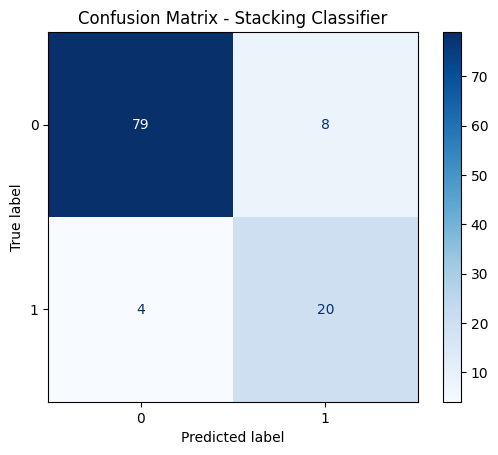

In [22]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Stacking Classifier')



#### Voting Classifier

In [23]:
from sklearn.ensemble import VotingClassifier

model_names = [
    "XGBoost",
    "Light GBM",
    "Decision Tree",
    "AdaBoost",
    "Naive Bayes",
    "BernoulliNB",
    "Logistic Regression",
]

evaluation_results2 = []
base = []
for j in range(len(model_names)):
    base.append((model_names[j], best_models[model_names[j]]))

stack = VotingClassifier(
    estimators=base,
    n_jobs=-1,
    voting="soft",
    weights=[1, 1, 1, 3, 0.2, 0.3, 0.8],
)
stack.fit(X_train, y_train)

y_pred_test = stack.predict(X_test)

train_acc = accuracy_score(y_train, stack.predict(X_train)) * 100 
train_f1 = f1_score(y_train, stack.predict(X_train)) * 100
train_roc = roc_auc_score(y_train, stack.predict_proba(X_train)[: , 1]) * 100
test_acc = accuracy_score(y_test, y_pred_test) * 100
test_f1 = f1_score(y_test, y_pred_test) * 100
test_roc = roc_auc_score(y_test, stack.predict_proba(X_test)[: , 1]) * 100

evaluation_results2.append(
    {
        "Train Accuracy": np.round(train_acc, 2),
        "Train F1 Score": np.round(train_f1, 2),
        "Train ROC AUC Score": np.round(train_roc, 2),
        "Test Accuracy": np.round(test_acc, 2),
        "Test F1 Score": np.round(test_f1, 2),
        "Test ROC AUC Score": np.round(test_roc, 2),  
    }
)

results2 = pd.DataFrame(data=evaluation_results2).T
results2


,0
Train Accuracy,94.56
Train F1 Score,89.09
Train ROC AUC Score,98.83
Test Accuracy,89.19
Test F1 Score,76.00
Test ROC AUC Score,87.31


Text(0.5, 1.0, 'Confusion Matrix - Voting Classifier')

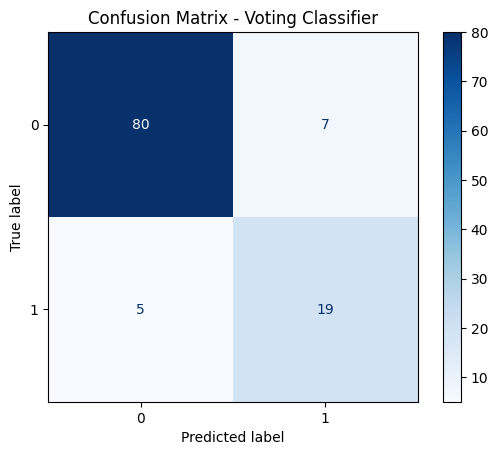

In [24]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Voting Classifier')

